In [1]:
from common import prepare_val
import torch

device = torch.device('cuda:0') # cuda:5
model_version = '2024_1219_161631'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val('GaussianLSS', device, CHECKPOINT_PATH, mode='val', batch_size=2)

Loaded pretrained weights for efficientnet-b4


/home/hcis-s20/miniconda3/envs/GaussianLSS/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hcis-s20/miniconda3/envs/GaussianLSS/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dataset length: 6019


In [2]:
for i,batch in enumerate(loader):
    print(i,end='\r')
    break

In [3]:
if CHECKPOINT_PATH is None:
    network.to(device)
    model.to(device)
    model.metrics.reset()
    with_grad = True

    if with_grad:
        network.train()
        # with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            if i != 0:
                continue
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            loss = model.loss_func(pred,batch)
            loss[0].backward()
            vis_result = viz(batch,pred)
            break
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is None:
                print(name)
    else:
        network.eval()
        with torch.no_grad():
            for i,batch in enumerate(loader):
                print(i,end='\r')
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        batch[k] = v.to(device)
                    elif isinstance(v, list):
                        if isinstance(v[0], torch.Tensor):
                            batch[k] = [i.to(device) for i in v]
                    else:
                        batch[k] = v
                pred = network(batch)
                model.metrics.update(pred,batch)
                # pred['mid_output']['sampled_feats'].retain_grad()
                # loss = model.loss_func(pred,batch)
                # loss[0].backward()
                # vis_result = viz(batch,pred)
                # if i == 25:
                break   
        
    model.metrics.update(pred,batch)


/home/hcis-s20/miniconda3/envs/GaussianLSS/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


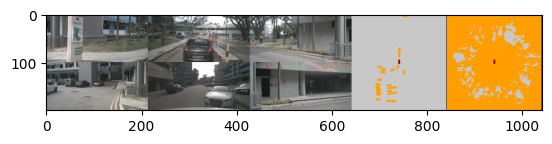

In [4]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.imshow(vis_result[1])